# Final Version 1a

<b><i> Identified [Aim](#aim) of the project as, see link to later in document

<div class="alert alert-block alert-info">
<b>Notes:</b><br>Induced Drag: Oswald efficiency number? https://en.wikipedia.org/wiki/Oswald_efficiency_number 
</div>

### External Modules

In [4]:
import numpy as np
import ADRpy as ADR
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### Environment Parameters

In [5]:
g = 9.81        #Gravitational Constant
rho = 1.225

# Wind Speed / Direcion
#     Headwind +ve
#     Cross wind +ve from right
w_vel = 0
w_deg = 0


rway_slope = 0   #Runway slope
mu = 0    #Driction Coefficient to Runway Surface



#Possibly ovveride given rho (using ISA altitudes)
temp_c = 0     #Airfield OAT temperacture in celcius
alt_ft = 0     #Airfield (runway) altitude in feet

<div class="alert alert-block alert-info">
Reasonable approximation of g to 9.81 as still very close to this. Density can be resonably approximated to 1.225 as very close to sea level given in relation. only change to the density will come from the temperature change, so use of ADRpy to calculate is ideal, on standard ISA non-offset (research into the offset and why used should be looked at)
</div>

### Aircraft Parameters

#### Airframe

In [6]:
m = 79000        #Mass [kg]
Cl_W = 0     #Cl Wing
Cl_T = 0     #Cl Tail
S = 0        #Wing Area
S_T = 0      #Tail Area
h_W = 0      #Height of wing above the ground

b = 0        #Wingspan
c = 0        #Chord length

In [7]:
#Total Cl for the aircraft
#Cl = Cl_W + (S_T / S) * Cl_T
Cl = 0

#### Engine

In [8]:
T = 106.8 * 1000    #Thrust per engine
n_e = 2   #Number of engines (evenly distributed per wing (i.e. 2 engines = 1 per wing))

### Engine Failure Parameters  (likely not be necessary*)
<i>* Due to running a balanced field model, engine failure is automatically used in calculating this, as such the needed for a failure speed isn't required (this will be covered by the calculated V1 speed). `However, the engine that fails is a parameter that will likely be used and will be an input controlled by the overall Monte Carlo analysis`

In [9]:
V_fail = 0    #Speed at which failure occurs
E_Ident = 0   #Engine Number to fail

<hr style="height:1px;border-width:0;color:black;background-color:black">

### Key Functions

- Lift
- Drag
- Ground Effect
- Friction
- Induced Drag
- phi
<br>

* ODEs for:
    * Velocity
    * Distance travelled

<div class="alert alert-block alert-warning">
Check definition of lift when using total Cl (i.e. when tail is included as well, which S is needed)
</div>
<div class="alert alert-block alert-warning">
Define Drag components seperately (Profile, Induced, Friction etc.) so that ODEs for the different stages can be more easily defined
</div>

In [10]:
def Lift(V):
    return 0.5 * rho * V**2 * S * Cl

def Drag(V):
    return None

def D_i(V):
    return 0

def D_f(V):
    R = m*g - Lift(V)
    return mu * R

`Introduction to Flight pg 320` <br>
$\phi = \large\frac{(16 h/b)^{2}}{1+(16 h/b)^{2}}$

In [11]:
phi = ((16*h_W/b)**2)/((1+((16*h_W/b)**2)))

ZeroDivisionError: division by zero

<hr style="height:1px;border-width:0;color:black;background-color:black">

### Calculating Stall Speed

For stall speed, the lift equals the weight of the aircraft. i.e $L=\frac{1}{2}\rho V^{2}C_{L}S=W=mg$
<br> 
Rearranging for V: $V= \sqrt{\frac{2mg}{\rho C_{L}S}}$

In [12]:
V_s = np.sqrt((2*m*g)/(rho))

### Calculating Rotation Speed

In [13]:
V_r = 1.2 * V_s

<div class="alert alert-block alert-info">
V1 is found by conducting the balanced field investigation for the parameters entered. <br><br> <a id='aim'></a><b> Aim to create a monte carlo analysis of balanced field lengths under enf=gine failures for a number of different aircraft parameters (should be able to input array for each of the paramters listed under Aircraft Parameters and Environmental Parameters sections above </b>
</div>

<hr style="height:1px;border-width:0;color:black;background-color:black">

### Defining and Solving the ODEs

<div class="alert alert-block alert-info">
    <b>Assume that the angle of the engine thrust is EQUAL to the AoA of the wing, i.e. engine parallel to wing</b>
</div>

In [14]:
Failed_Engine = "N" #N - No failure, #L{0} - Left Failure & how many, #R{0} - Right Failure & how many

In [15]:
#Total engine thrust (per side?)
#T_L = (n_e / 2) * T
#T_R = (n_e / 2) * T

Failed_Engine = Failed_Engine.upper()

if Failed_Engine == "N":
    T_L = T_R = (n_e / 2) * T
    
elif 'L' in Failed_Engine:
    e_p = n_e / 2
    T_L = (e_p - int(Failed_Engine[1:])) * T
    T_R = (n_e / 2) * T
else:
    e_p = n_e / 2
    T_L = (n_e / 2) * T
    T_R = (e_p - int(Failed_Engine[1:])) * T
T_L, T_R

(106800.0, 106800.0)

In [ ]:
t_a = 25

def dV(t,V):
    if t <= t_a:
        #return (T_L + T_R - D_i - D_f)/m
        return (T_L + T_R - D_i(V) - D_f(V))/m
    else:
        return -6
    
def f(t,y):
    S = y[0]
    V = y[1]
    dSdt = V
    dVdt = dV(t,V)
    
    return np.array([dSdt,dVdt])

def full_stop(t, y): return y[0]
full_stop.terminal = True
full_stop.direction = -1

In [ ]:
%%time
V1 = solve_ivp(dV,[0,40],[0],rtol=1e-9,events=full_stop)

In [ ]:
#1.t, V1.y[0], V1.t_events


In [ ]:
%%time
y0=np.array([0,0])

S = solve_ivp(f,[0,V1.t_events[0]],y0,rtol=1e-9,max_step=1e-3,method='LSODA')

In [ ]:
plt.plot(V1.t,V1.y[0])

In [ ]:
plt.plot(S.t,S.y[0])

- Acc-Stop
    - All Engines
    - Engine Failure
- Take-off Go
    - All Engines
    - Engine Failure

In [75]:
t_a = 50
V_a = 150 *0.5144

def dV(t,V):
    if t <= t_a:
        #return (T_L + T_R - D_i - D_f)/m
        return (T_L + T_R - D_i(V) - D_f(V))/m
    else:
        return -0.5*9.81
    
def f(t,y):
    S = y[0]
    V = y[1]
    dSdt = V
    dVdt = dV(t,V)
    
    return np.array([dSdt,dVdt])

def full_stop(t, y): return y[0]
full_stop.terminal = True
full_stop.direction = -1

def AbortSpeed(t,y): return y[0] - V_a
AbortSpeed.terminal = False
AbortSpeed.direction = 1

In [76]:
%%time
V1 = solve_ivp(dV,[0,40],[0],rtol=1e-9,events=[full_stop,AbortSpeed])

Wall time: 2.99 ms


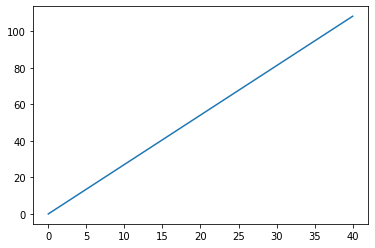

In [77]:
plt.plot(V1.t,V1.y[0])

In [78]:
V1.t_events

[array([], dtype=float64), array([28.53764045])]

In [79]:
%%time
t_a = V1.t_events[1][0]
t_a
V_1a = solve_ivp(dV,[0,80],[0],rtol=1e-9,events=[full_stop,AbortSpeed])

Wall time: 6.98 ms


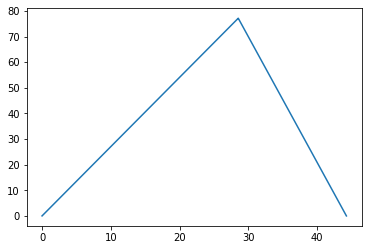

In [80]:
plt.plot(V_1a.t,V_1a.y[0])

In [81]:
V_1a.t_events

[array([44.26852696]), array([], dtype=float64)]

Initial guess, refine and run again

## Trying another method

In [202]:
t_a = 30 #Initial guess
V_a = 25 #Actual abort speed

def dV_accel(t,V):
    return (T_L + T_R - D_i(V) - D_f(V))/m
    
def dV_brake(t,V):
    return -0.5*9.81

dV = dV_accel

def f(t,y):
    S = y[0]
    V = y[1]
    dSdt = V
    dVdt = dV(t,V)
    
    return np.array([dSdt,dVdt])

def full_stop(t, y): return y[0]
full_stop.terminal = True
full_stop.direction = -1

def AbortSpeed(t,y):
    if y[0] > V_a:
        dV = dV_brake
    return y[0] - V_a
AbortSpeed.terminal = True
AbortSpeed.direction = 0

In [203]:
%%time
V1b = solve_ivp(dV_accel,[0,50],[0],rtol=1e-9,max_step=1e-3,events=[AbortSpeed])
V1b1 = solve_ivp(dV_brake,[V1b.t[-1],50],[V1b.y[0][-1]],rtol=1e-9,max_step=1e-3,events=[full_stop])

Wall time: 5.17 s


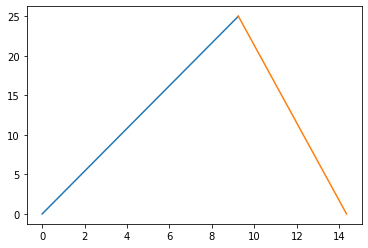

In [204]:
plt.plot(V1b.t,V1b.y[0])
plt.plot(V1b1.t,V1b1.y[0])

In [205]:
V1b.t_events

[array([9.24625468])]

In [206]:
np.max(V1b.y[0])

24.999999999999996

In [207]:
sol = [[],[]]

In [208]:
sol[0] = np.concatenate([V1b.t,V1b1.t])
sol[1] = np.concatenate([V1b.y[0],V1b1.y[0]])

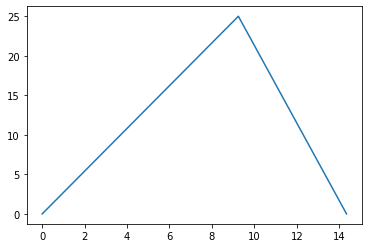

In [209]:
plt.plot(sol[0],sol[1])